In [1]:
# ============================================================================
# 导入所有必需的库和模块
# ============================================================================

# 基础库
import pandas as pd
import numpy as np
import json
import warnings
warnings.filterwarnings('ignore')

# 可视化
import matplotlib.pyplot as plt
import seaborn as sns

# API 和模型
from ambiguity_detection_utils import AmbiguityDetector
from ollama import Client
from prompts import PSEUDOCODE_PROMPT_TEMPLATE

# 深度学习模型
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel

# 机器学习评估指标
from sklearn.metrics import (
    roc_auc_score, roc_curve, f1_score, 
    precision_recall_curve, auc,
    confusion_matrix, classification_report, 
    accuracy_score
)

print("所有库导入完成！")

所有库导入完成！


In [2]:
# ============================================================================
# 创建检测器和加载数据
# ============================================================================

# 创建语义歧义检测器
detector = AmbiguityDetector("semantic")

# 加载并准备数据
file_path = r"data/User Story Ambiguity Dataset_A Comprehensive Research Resource/Cornelius_2025_user_story_ambiguity_dataset.xlsx"
df_test = detector.load_and_prepare_data(file_path, create_balanced=True)

print(f"测试数据集: {len(df_test)} 个用户故事")

Semantic歧义统计:
  有semantic歧义: 2831 (22.0%)
  无semantic歧义: 10016 (78.0%)
平衡测试集: 5662 个用户故事
  HasAmbiguity=True: 2831 (50.0%)
  HasAmbiguity=False: 2831 (50.0%)
测试数据集: 5662 个用户故事


In [3]:
df_test = df_test.sample(n=100, random_state=42)
df_test.head()

,StoryID,StoryText,HasAmbiguity
5436,US-C7-12387,"As a store owner, I would like to search produ...",False
5102,US-C3-6378,"As a customer, I would like to handle orders t...",True
3694,US-C2-3975,"As a nurse, I want to process medical informat...",True
1499,US-C4-8257,"As a network admin, I would like to report out...",False
2698,US-C3-6132,"As a customer, I want to add to cart so that I...",False


In [4]:
df_test.count()

StoryID         100
StoryText       100
HasAmbiguity    100
dtype: int64

In [5]:
ollama_client = Client(
    host="http://2yo6159kw603.vicp.fun/",
)

In [6]:
print("加载 CodeBERT 模型...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# 加载 CodeBERT 模型和分词器
model_name = "microsoft/codebert-base"
code_tokenizer = AutoTokenizer.from_pretrained(model_name)
code_model = AutoModel.from_pretrained(model_name).to(device)

print(f"CodeBERT 模型已加载")
print(f"模型名称: {model_name}")
print(f"设备: {device}")

加载 CodeBERT 模型...
使用设备: cuda
CodeBERT 模型已加载
模型名称: microsoft/codebert-base
设备: cuda


In [7]:
# 定义代码embedding函数
def get_code_embedding(code_text, tokenizer, model, device):
    """
    获取代码文本的embedding向量（使用CodeBERT）
    
    使用 CodeBERT 的 [CLS] token 表示作为整个代码段的语义表示
    
    参数:
        code_text: 代码文本
        tokenizer: AutoTokenizer 分词器
        model: AutoModel CodeBERT 模型
        device: 计算设备 (cuda/cpu)
    
    返回:
        embedding: 代码embedding向量 (768,)，已转换为 numpy 数组
    """
    # 对输入进行分词并转换为 token IDs
    tokens = tokenizer(
        code_text,
        max_length=512,
        truncation=True,
        padding='max_length',
        return_tensors='pt'
    ).to(device)
    
    # 获取模型输出
    with torch.no_grad():
        outputs = model(**tokens)
        # outputs[0] 是最后一层的所有 token 的表示，shape: (batch_size, seq_len, hidden_size)
        # 我们取 [CLS] token 的表示（第一个 token）作为整个代码段的表示
        cls_embedding = outputs.last_hidden_state[:, 0, :]  # shape: (1, 768)
    
    # 转换为 numpy 数组并返回
    return cls_embedding.cpu().numpy().squeeze()  # 返回 (768,)

print("get_code_embedding 函数已定义")

get_code_embedding 函数已定义


In [8]:
# 定义计算伪代码相似度分数的函数
def calculate_pseudocode_similarity_score(pseudocodes, tokenizer, model, device):
    """
    计算伪代码批次的相似度分数
    
    使用 CodeBERT 获取代码语义表示，根据论文方法计算歧义分数：
    g(P_i^(q)) = ∑_{(p_ij, p_ij') ∈ P_i^(q) × P_i^(q)} (1 - sim(p_ij, p_ij'))
    
    其中 sim 是基于 CodeBERT 语义表示的余弦相似度，范围 [0, 1]
    
    参数:
        pseudocodes: 伪代码列表
        tokenizer: AutoTokenizer 分词器
        model: AutoModel CodeBERT 模型
        device: 计算设备 (cuda/cpu)
    
    返回:
        score: 伪代码歧义分数（高分表示高歧义）
        similarity_matrix: 相似度矩阵 (n, n)，值在 [0, 1] 范围内
    """
    n = len(pseudocodes)
    
    if n < 2:
        return 0.0, np.array([[1.0]])
    
    # 1. 为所有伪代码获取 CodeBERT embedding
    embeddings = []
    for pseudocode in pseudocodes:
        try:
            embedding = get_code_embedding(pseudocode, tokenizer, model, device)
            embeddings.append(embedding)
        except Exception as e:
            print(f"获取 embedding 失败: {str(e)}")
            # 如果失败，返回零向量
            embeddings.append(np.zeros(768))
    
    embeddings = np.array(embeddings)  # shape: (n, 768)
    
    # 2. 规范化 embedding 向量
    embeddings_norm = embeddings / (np.linalg.norm(embeddings, axis=1, keepdims=True) + 1e-8)
    
    # 3. 计算所有伪代码对的余弦相似度矩阵
    # 余弦相似度 = dot(u, v) / (||u|| * ||v||)
    # 由于我们已经规范化，直接做矩阵乘法
    similarity_matrix = np.dot(embeddings_norm, embeddings_norm.T)  # shape: (n, n)
    
    # 确保相似度在 [0, 1] 范围内（由于浮点误差可能略超）
    similarity_matrix = np.clip(similarity_matrix, 0.0, 1.0)
    
    # 4. 计算歧义分数：所有非对角线元素的（1 - 相似度）之和
    score = 0.0
    for i in range(n):
        for j in range(n):
            if i != j:
                dissimilarity = 1.0 - similarity_matrix[i][j]
                score += dissimilarity
    
    return score, similarity_matrix

print("calculate_pseudocode_similarity_score 函数已定义")

calculate_pseudocode_similarity_score 函数已定义


In [9]:
prompt_template = PSEUDOCODE_PROMPT_TEMPLATE

# 定义清理伪代码的函数
def clean_pseudocode(pseudocode_text):
    """
    清理伪代码中的 markdown code block 标记
    
    移除开头的 ```pseudocode、``` 或 ```\n
    移除结尾的 ```
    
    参数:
        pseudocode_text: 原始伪代码文本
    
    返回:
        cleaned_text: 清理后的伪代码文本
    """
    text = pseudocode_text.strip()
    
    # 移除开头的 markdown 标记
    if text.startswith('```pseudocode'):
        text = text[len('```pseudocode'):].lstrip('\n')
    elif text.startswith('```'):
        text = text[3:].lstrip('\n')
    
    # 移除结尾的 ``` 标记
    if text.endswith('```'):
        text = text[:-3].rstrip()
    
    return text.strip()

print("clean_pseudocode 函数已定义")

clean_pseudocode 函数已定义


In [ ]:
# 14. 生成伪代码 - 为每个需求生成10份伪代码
# 使用前面的df_test数据（前10个故事）
pseudocode_results = []

print("开始生成伪代码...\n")

for index, row in df_test.iterrows():
    story_id = row['StoryID']
    story_text = row['StoryText']
    pseudocodes = []
    
    print(f"处理故事 {index + 1}/{len(df_test)}: {story_id}")
    
    # 为该故事生成10份伪代码
    for attempt in range(10):
        # 使用导入的模板，通过 format() 替换 {REQUIREMENT} 占位符
        formatted_prompt = PSEUDOCODE_PROMPT_TEMPLATE.format(REQUIREMENT=story_text)
        
        try:
            response = ollama_client.chat(model='gpt-oss:20b', messages=[
                {
                    'role': 'user',
                    'content': formatted_prompt,
                },
            ])
            pseudocode = response.message.content
            # 清理伪代码中的 markdown 标记
            pseudocode = clean_pseudocode(pseudocode)
            pseudocodes.append(pseudocode)
            print(f"  生成伪代码 {attempt + 1}/10")
        except Exception as e:
            print(f"  生成伪代码 {attempt + 1}/10 失败: {str(e)}")
            pseudocodes.append(f"Error: {str(e)}")
    
    # 计算该故事的伪代码相似度分数
    if all(not pc.startswith("Error") for pc in pseudocodes):
        try:
            score, similarity_matrix = calculate_pseudocode_similarity_score(
                pseudocodes,
                code_tokenizer,
                code_model,
                device
            )
            pseudocode_ambiguity_level = 'High' if score > 5 else ('Medium' if score > 2 else 'Low')
        except Exception as e:
            print(f"  计算相似度分数失败: {str(e)}")
            score = 0.0
            similarity_matrix = np.array([[1.0]])
            pseudocode_ambiguity_level = 'Error'
    else:
        score = 0.0
        similarity_matrix = np.array([[1.0]])
        pseudocode_ambiguity_level = 'Error'
    
    pseudocode_results.append({
        'StoryID': story_id,
        'StoryText': story_text,
        'HasAmbiguity': row['HasAmbiguity'],
        'NumPseudocodes': len(pseudocodes),
        'PseudocodeScore': score,
        'PseudocodePseudocodeAmbiguityLevel': pseudocode_ambiguity_level,
        'Pseudocodes': pseudocodes
    })
    
    print(f"  相似度分数: {score:.4f}, 歧义级别: {pseudocode_ambiguity_level}\n")

print(f"完成生成 {len(pseudocode_results)} 个故事的伪代码")

开始生成伪代码...

处理故事 5437/100: US-C7-12387
  生成伪代码 1/10
  生成伪代码 2/10
  生成伪代码 3/10
  生成伪代码 4/10
  生成伪代码 5/10
  生成伪代码 6/10
  生成伪代码 7/10
  生成伪代码 8/10
  生成伪代码 9/10
  生成伪代码 10/10
  相似度分数: 0.3981, 歧义级别: Low

处理故事 5103/100: US-C3-6378
  生成伪代码 1/10
  生成伪代码 2/10
  生成伪代码 3/10
  生成伪代码 4/10
  生成伪代码 5/10
  生成伪代码 6/10
  生成伪代码 7/10
  生成伪代码 8/10
  生成伪代码 9/10
  生成伪代码 10/10
  相似度分数: 0.5040, 歧义级别: Low

处理故事 3695/100: US-C2-3975
  生成伪代码 1/10
  生成伪代码 2/10
  生成伪代码 3/10
  生成伪代码 4/10
  生成伪代码 5/10
  生成伪代码 6/10
  生成伪代码 7/10
  生成伪代码 8/10
  生成伪代码 9/10
  生成伪代码 10/10
  相似度分数: 0.4987, 歧义级别: Low

处理故事 1500/100: US-C4-8257
  生成伪代码 1/10
  生成伪代码 2/10
  生成伪代码 3/10
  生成伪代码 4/10
  生成伪代码 5/10
  生成伪代码 6/10
  生成伪代码 7/10
  生成伪代码 8/10
  生成伪代码 9/10
  生成伪代码 10/10
  相似度分数: 0.4026, 歧义级别: Low

处理故事 2699/100: US-C3-6132
  生成伪代码 1/10
  生成伪代码 2/10
  生成伪代码 3/10
  生成伪代码 4/10
  生成伪代码 5/10
  生成伪代码 6/10
  生成伪代码 7/10
  生成伪代码 8/10
  生成伪代码 9/10
  生成伪代码 10/10
  相似度分数: 0.3840, 歧义级别: Low

处理故事 4109/100: US-C1-550
  生成伪代码 1/10
  生成伪代码 2/10
  生成伪代码 3/1

In [ ]:
pseudocode_results[0]["Pseudocodes"]

['```\n# Data structures --------------------------------------------------------------\n\nclass Seller:\n    id\n    name\n    authToken\n\nclass Order:\n    id\n    sellerId\n    status          # e.g., "Processing", "Shipped", "Delivered"\n    items           # list of Item objects\n\nclass Item:\n    id\n    name\n    specifications  # dict of specName -> specValue\n    requirements    # list of Requirement objects\n\nclass Requirement:\n    id\n    description\n    category        # e.g., "Quality", "Compliance", "Packaging"\n\n# Core functions ---------------------------------------------------------------\n\nfunction loginSeller(credentials):\n    # Authenticate seller and return a Seller object with authToken\n    seller = authenticate(credentials)\n    return seller\n\nfunction fetchOrder(seller, orderId):\n    # Retrieve order data for this seller\n    order = getOrderFromDatabase(orderId)\n    if order.sellerId != seller.id:\n        raise PermissionError\n    return order\n

In [ ]:
# 创建DataFrame用于分析
scores_df = pd.DataFrame(pseudocode_results)
print(f"\n完成处理 {len(pseudocode_results)} 个用户故事")
print("\n澄清分数统计:")
print(scores_df[['NumPseudocodes', 'PseudocodeScore', 'PseudocodePseudocodeAmbiguityLevel']].describe())


完成处理 5 个用户故事

澄清分数统计:
       NumPseudocodes  PseudocodeScore
count             5.0         5.000000
mean             10.0         0.464174
std               0.0         0.110574
min              10.0         0.364963
25%              10.0         0.367348
50%              10.0         0.457957
75%              10.0         0.497489
max              10.0         0.633111


In [ ]:
scores_df

,StoryID,StoryText,HasAmbiguity,NumPseudocodes,PseudocodeScore,PseudocodeAmbiguityLevel,Pseudocodes
0,US-C3-6636,"As a seller, I would like to track order to fi...",False,10,0.497489,Low,[```\n# Data structures ----------------------...
1,US-C7-12360,"As a store owner, I want to track order in ord...",False,10,0.364963,Low,[```\n// Data structures\nclass ItemSpec:\n ...
2,US-C2-3691,"As a patient, I need to access records so that...",False,10,0.367348,Low,[```\n# Data structures\nPatientRecord = {\n ...
3,US-C5-9039,"As a investor, I want to handle finances in or...",True,10,0.457957,Low,[```pseudocode\n//----------------------------...
4,US-C1-610,"As a financial advisor, I need to manage accou...",True,10,0.633111,Low,[```\n# Data structures\nclass Account:\n i...


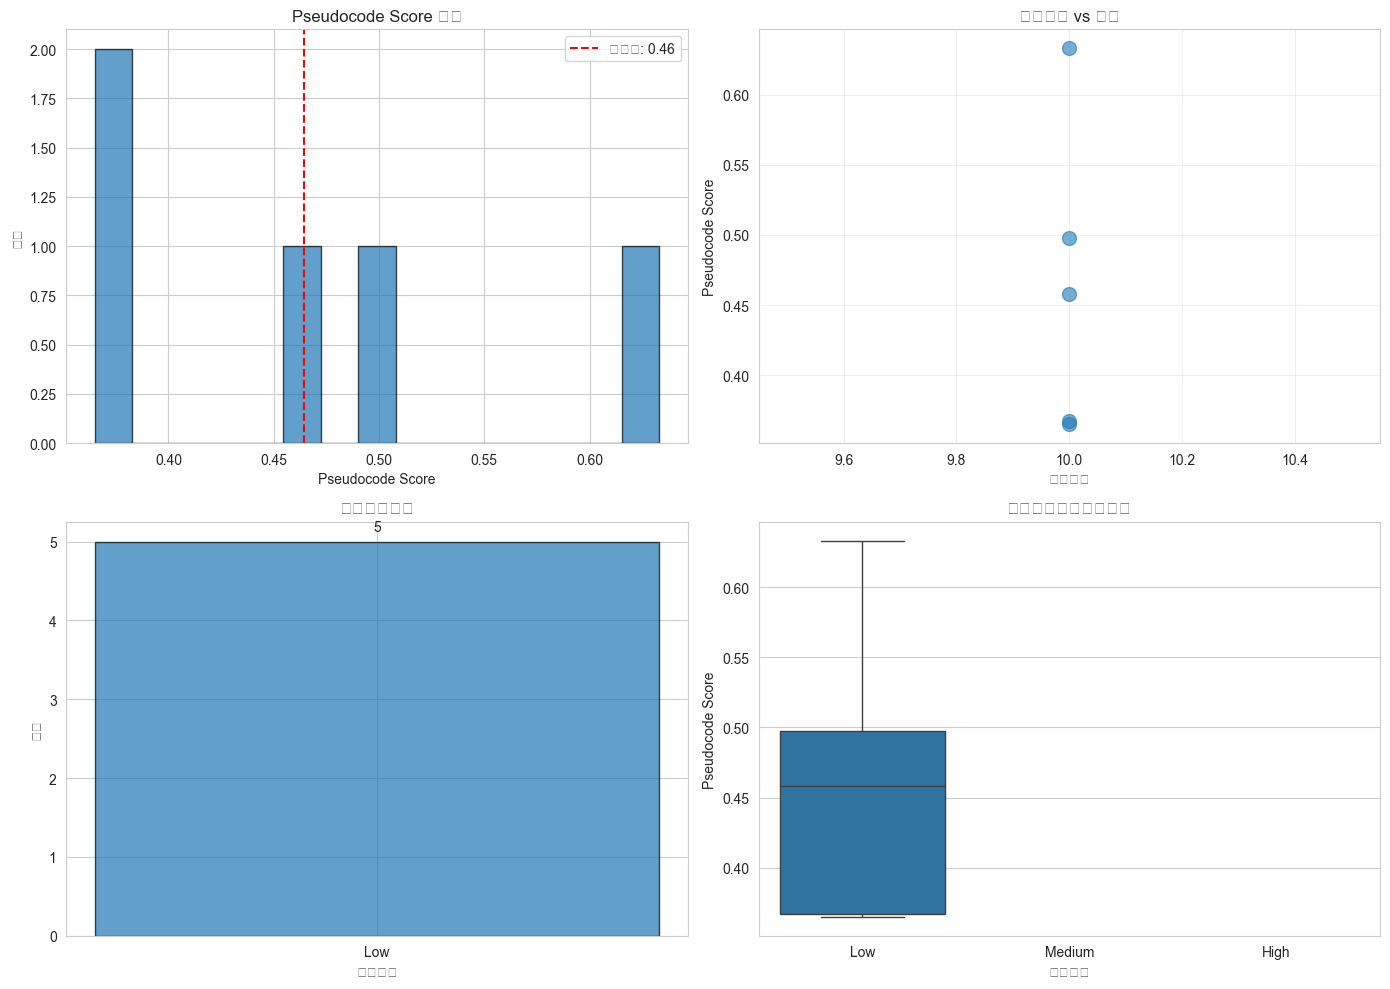

分析结果已保存到 clarification_score_analysis.png


In [ ]:
# 6. 可视化分析结果
# 设置图表风格
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)

# 创建子图
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Pseudocode Score 分布直方图
axes[0, 0].hist(scores_df['PseudocodeScore'], bins=15, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Pseudocode Score')
axes[0, 0].set_ylabel('频率')
axes[0, 0].set_title('Pseudocode Score 分布')
axes[0, 0].axvline(scores_df['PseudocodeScore'].mean(), color='red', linestyle='--', label=f'平均值: {scores_df["PseudocodeScore"].mean():.2f}')
axes[0, 0].legend()

# 2. 澄清数量 vs 分数散点图
axes[0, 1].scatter(scores_df['NumPseudocodes'], scores_df['PseudocodeScore'], alpha=0.6, s=100)
axes[0, 1].set_xlabel('澄清数量')
axes[0, 1].set_ylabel('Pseudocode Score')
axes[0, 1].set_title('澄清数量 vs 分数')
axes[0, 1].grid(True, alpha=0.3)

# 3. 歧义级别分布
ambiguity_counts = scores_df['PseudocodeAmbiguityLevel'].value_counts()
axes[1, 0].bar(ambiguity_counts.index, ambiguity_counts.values, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('歧义级别')
axes[1, 0].set_ylabel('数量')
axes[1, 0].set_title('歧义级别分布')
for i, v in enumerate(ambiguity_counts.values):
    axes[1, 0].text(i, v + 0.1, str(v), ha='center', va='bottom')

# 4. 评分箱线图（按歧义级别）
order = ['Low', 'Medium', 'High']
scores_df_sorted = scores_df.copy()
scores_df_sorted['PseudocodeAmbiguityLevel'] = pd.Categorical(scores_df_sorted['PseudocodeAmbiguityLevel'], categories=order, ordered=True)
sns.boxplot(data=scores_df_sorted, x='PseudocodeAmbiguityLevel', y='PseudocodeScore', ax=axes[1, 1])
axes[1, 1].set_xlabel('歧义级别')
axes[1, 1].set_ylabel('Pseudocode Score')
axes[1, 1].set_title('各歧义级别的分数分布')

plt.tight_layout()
plt.savefig('clarification_score_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("分析结果已保存到 clarification_score_analysis.png")

In [ ]:
# 8. 计算 AUROC 和 F1 分数用于评估歧义检测性能
# 合并 df_test 的真实标签和 scores_df 的预测分数
# 创建一个映射字典，将 StoryID 与 HasAmbiguity 对应
true_labels_dict = dict(zip(df_test['StoryID'], df_test['HasAmbiguity']))

# 为 scores_df 添加真实标签
scores_df['TrueLabel'] = scores_df['StoryID'].map(true_labels_dict)

# 移除没有真实标签的行
scores_df_with_labels = scores_df.dropna(subset=['TrueLabel'])

print(f"用于评估的样本数: {len(scores_df_with_labels)}")
print(f"真实标签分布:")
print(scores_df_with_labels['TrueLabel'].value_counts())
print()

# 准备数据
y_true = scores_df_with_labels['TrueLabel'].astype(int).values
y_scores = scores_df_with_labels['PseudocodeScore'].values

# 1. 计算 AUROC
auroc = roc_auc_score(y_true, y_scores)
print(f"消歧方法 - AUROC: {auroc:.4f}")

# 获取ROC曲线的FPR和TPR
fpr, tpr, roc_thresholds = roc_curve(y_true, y_scores)

# 2. 寻找最优的阈值（使用约登指数）
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = roc_thresholds[optimal_idx]

print(f"最优阈值（基于约登指数）: {optimal_threshold:.4f}")

# 3. 使用最优阈值进行二分类
y_pred = (y_scores >= optimal_threshold).astype(int)

# 4. 计算 F1 分数
f1 = f1_score(y_true, y_pred)
print(f"消歧方法 - F1 Score: {f1:.4f}")

# 5. 计算其他评估指标（用于可视化和后续分析，但不在主要输出中突出）
accuracy = accuracy_score(y_true, y_pred)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0

# 6. Precision-Recall 曲线
precision_vals, recall_vals, pr_thresholds = precision_recall_curve(y_true, y_scores)
pr_auc = auc(recall_vals, precision_vals)

print("\n" + "="*50)
print(f"\n总结:")
print(f"  AUROC: {auroc:.4f}")
print(f"  F1 Score: {f1:.4f}\n")
print("="*50)

用于评估的样本数: 5
真实标签分布:
TrueLabel
False    3
True     2
Name: count, dtype: int64

消歧方法 - AUROC: 0.8333
最优阈值（基于约登指数）: 0.4580
消歧方法 - F1 Score: 0.8000


总结:
  AUROC: 0.8333
  F1 Score: 0.8000



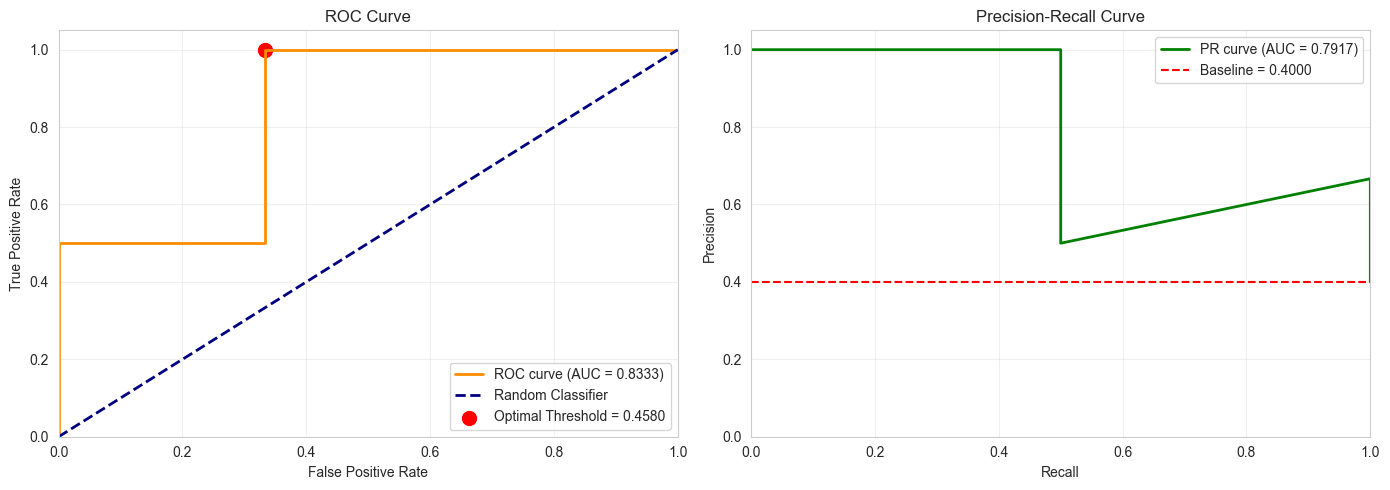

评估曲线已保存到 ambiguity_detection_evaluation.png

PR-AUC (Precision-Recall AUC): 0.7917


In [ ]:
# 9. 可视化 ROC 曲线和 Precision-Recall 曲线
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC 曲线
axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auroc:.4f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[0].scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', s=100, 
                label=f'Optimal Threshold = {optimal_threshold:.4f}')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend(loc="lower right")
axes[0].grid(True, alpha=0.3)

# Precision-Recall 曲线
precision_vals, recall_vals, pr_thresholds = precision_recall_curve(y_true, y_scores)
pr_auc = auc(recall_vals, precision_vals)

axes[1].plot(recall_vals, precision_vals, color='green', lw=2, label=f'PR curve (AUC = {pr_auc:.4f})')
axes[1].axhline(y=np.sum(y_true) / len(y_true), color='red', linestyle='--', 
                label=f'Baseline = {np.sum(y_true) / len(y_true):.4f}')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve')
axes[1].legend(loc="upper right")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ambiguity_detection_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

print("评估曲线已保存到 ambiguity_detection_evaluation.png")
print(f"\nPR-AUC (Precision-Recall AUC): {pr_auc:.4f}")